---
authors:
  - name: Mathis Derenne
    affiliation: M2 MIASHS - Université de Lyon
    github: mathisdrn
  - name: Djida Boukari
    affiliation: M2 MIASHS - Université de Lyon
  - name: Ines Nakhli
    affiliation: M2 MIASHS - Université de Lyon
date: 2026-02-01
---

# Prédiction conforme

## Introduction

Ce notebook implémente une procédure de **Weighted Split Conformal Prediction (WSCP)** appliquée à un modèle de survie XGBoost AFT (Accelerated Failure Time).

Contrairement à la régression classique, l'analyse de survie présente un défi majeur pour la prédiction conforme : la **censure**.
- Si nous calculons les scores de non-conformité uniquement sur les patients non-censurés, nous introduisons un **biais de sélection** (les patients observés ont tendance à avoir des événements plus précoces).
- Nous ne pouvons pas calculer l'erreur exacte pour les patients censurés car leur vrai temps de survie $T$ est inconnu (nous savons seulement $T > C$).

## Méthodologie : Weighted Conformal Prediction

Pour garantir la couverture malgré la censure, nous utilisons une approche de re-pondération (**IPCW - Inverse Probability of Censoring Weighting**) :

1.  **Séparation :** Division du jeu d'entraînement en un ensemble d'**Entraînement Propre** (pour ajuster le modèle) et un ensemble de **Calibration** (pour calculer les seuils).
2.  **Modélisation de la Censure :** Estimation de la distribution de la censure $\hat{G}(t) = P(C > t)$ sur l'ensemble de calibration via Kaplan-Meier.
3.  **Calcul des Scores :** Pour les patients non-censurés de l'ensemble de calibration, nous calculons le résidu absolu standardisé : $s_i = |\log(T_i) - \hat{f}(X_i)|$.
4.  **Pondération :** Chaque score $s_i$ reçoit un poids $w_i = \frac{1}{\hat{G}(T_i)}$ pour compenser la sous-représentation des temps longs due à la censure.
5.  **Quantile Pondéré :** Nous calculons le quantile $(1-\alpha)$ pondéré de ces scores pour obtenir la marge d'erreur $q$.
6.  **Intervalles :** Les intervalles de prédiction pour le temps de survie sont donnés par $[\exp(\hat{f}(X) - q), \exp(\hat{f}(X) + q)]$.

## Imports et configuration

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

# Polars display options
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_float_precision(3)
pl.Config.set_tbl_hide_column_data_types(True);

## Chargement et préparation des données

Pour la prédiction conforme, il est crucial de créer un **ensemble de calibration distinct** qui n'a pas été utilisé pour l'entraînement du modèle XGBoost, afin d'éviter le sur-ajustement des résidus.

In [3]:
from sklearn.model_selection import train_test_split

# Load data and convert to Pandas immediately for easier slicing
df_train = pd.read_parquet("../../data/df_study_L18_w6_train.parquet")
df_test = pd.read_parquet("../../data/df_study_L18_w6_test.parquet")

# Split Train/Calib (defining X and y inputs directly in the function call)
X_train, X_calib, y_train, y_calib = train_test_split(
    df_train.drop(columns=["event", "time"]),
    df_train[["event", "time"]],
    test_size=0.2,
    random_state=42,
    stratify=df_train["event"],
)

# Prepare Test
X_test = df_test.drop(columns=["event", "time"])
y_test = df_test[["event", "time"]]

print(f"Train: {len(X_train)}, Calib: {len(X_calib)}, Test: {len(X_test)}")

Train: 1904, Calib: 477, Test: 1174


## Entraînement du modèle 

On choisit le modèle qui a montré les meilleures performances : XGBoost AFT.

Le modèle est configuré en mode AFT (`survival:aft`) avec une distribution normale, ce qui signifie qu'il modélise $\log(T) \sim \mathcal{N}(f(X), \sigma)$.

In [ ]:
import xgboost as xgb

# Création des DMatrix pour XGBoost
# AFT nécessite les bornes inférieures et supérieures pour la censure
# Non-censuré (event=1) : lower=time, upper=time
# Censuré (event=0) : lower=time, upper=+inf
dtrain = xgb.DMatrix(
    X_train,
    label_lower_bound=y_train["time"],
    label_upper_bound=np.where(y_train["event"], y_train["time"], np.inf),
)

# Configuration des hyperparamètres
params = {
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "aft_loss_distribution": "normal",
    "aft_loss_distribution_scale": 1.0,
    "tree_method": "hist",
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
}

bst = xgb.train(params, dtrain, num_boost_round=300)

## Weighted Conformal Prediction : Étape 1 (Gestion de la Censure)

Pour corriger le biais induit par la censure dans l'ensemble de calibration, nous utilisons l'**IPCW**.
Nous ajustons un estimateur de Kaplan-Meier sur la variable de censure $C$ (en inversant l'indicateur d'événement : `1 - event`).

Les poids pour les individus non-censurés seront $w_i = 1 / \hat{G}(T_i)$.


In [ ]:
from lifelines import KaplanMeierFitter

# 1. Ajustement de la distribution de la censure G(t) = P(C > t)
kmf_censoring = KaplanMeierFitter()
kmf_censoring.fit(
    durations=y_calib["time"],
    event_observed=1 - y_calib["event"],  # On inverse : 1=Censuré, 0=Mort
)

# 2. Calcul des poids pour l'ensemble de calibration
# On récupère la probabilité de censure au temps T_i
g_hat = kmf_censoring.predict(y_calib["time"])

# On évite la division par zéro en clippant les probabilités très faibles
g_hat = np.clip(g_hat, 0.01, 1.0)
weights_calib = 1.0 / g_hat

# Les poids ne sont pertinents que pour les événements observés (là où on calcule l'erreur)
# Pour les censurés, le poids sera techniquement 0 dans le calcul du quantile (voir suite)
df_calib_res = pl.DataFrame(
    {"time": y_calib["time"], "event": y_calib["event"], "weight": weights_calib}
)

print("Distribution de la censure estimée via Kaplan-Meier.")
df_calib_res.head()


Distribution de la censure estimée via Kaplan-Meier.


time,event,weight
1673.000,false,1.286
589.000,true,1.006
771.000,true,1.026
959.000,true,1.086
2636.000,false,1.703


## Weighted Conformal Prediction : Étape 2 (Scores et Quantile) 

1. Nous effectuons les prédictions sur l'ensemble de calibration. Le modèle AFT prédit $\log(\text{Time})$.
2. Nous calculons les **scores de non-conformité** : $s_i = |\log(T_i) - \log(\hat{y}_i)|$ uniquement pour les individus non-censurés ($\delta_i=1$).
3. Nous calculons le quantile pondéré $1-\alpha$ de ces scores.

In [ ]:
# Prédiction sur calibration
dcalib = xgb.DMatrix(X_calib)
y_pred_raw_calib = bst.predict(dcalib)

# Ajout des prédictions au DataFrame
# On s'assure que les prédictions sont positives avant le log
df_calib_res = df_calib_res.with_columns(
    predicted_time=pl.Series(y_pred_raw_calib).fill_nan(0).clip(1e-5, np.inf)
)

# Calcul des résidus (Scores de non-conformité)
# Formule : | log(Vrai Temps) - log(Temps Prédit) |
df_calib_scores = df_calib_res.filter(pl.col("event") == 1).with_columns(
    nonconformity_score=(pl.col("time").log() - pl.col("predicted_time").log()).abs()
)


# Fonction pour le quantile pondéré
def weighted_quantile(values: np.ndarray, weights: np.ndarray, q: float) -> np.ndarray:
    """Calcule le quantile q pondéré d'une série de valeurs."""
    sorted_indices = np.argsort(values)
    sorted_values = np.array(values)[sorted_indices]
    sorted_weights = np.array(weights)[sorted_indices]

    cum_weights = np.cumsum(sorted_weights)
    cum_weights /= cum_weights[-1]

    idx = np.searchsorted(cum_weights, q)
    return sorted_values[idx]


# Calcul du quantile conforme
ALPHA = 0.10
scores = df_calib_scores["nonconformity_score"].to_numpy()
w = df_calib_scores["weight"].to_numpy()

q_hat = weighted_quantile(scores, w, 1 - ALPHA)

print(f"Nombre de points de calibration (non-censurés) : {len(scores)}")
print(f"Quantile pondéré (alpha={ALPHA}) q_hat : {q_hat:.4f}")
print(
    f"Cela correspond à un facteur multiplicatif de temps de : exp({q_hat:.2f}) = {np.exp(q_hat):.2f}x"
)

Nombre de points de calibration (non-censurés) : 321
Quantile pondéré (alpha=0.1) q_hat : 1.2088
Cela correspond à un facteur multiplicatif de temps de : exp(1.21) = 3.35x


## Construction des Intervalles sur le Test Set

Pour chaque patient du test set, l'intervalle de prédiction est :
$$ \hat{C}(X) = \left[ \exp(\hat{y} - \hat{q}), \exp(\hat{y} + \hat{q}) \right] $$
Où $\hat{y}$ est la prédiction log-temps du modèle.

In [ ]:
# Prédiction sur le test set (Temps brut)
dtest = xgb.DMatrix(X_test)
y_pred_raw_test = bst.predict(dtest)

# Passage en log pour appliquer la borne conforme
y_pred_log_test = np.log(np.maximum(y_pred_raw_test, 1e-5))

# Construction des intervalles (retour à l'échelle temporelle via exp)
lower_bound = np.exp(y_pred_log_test - q_hat)
upper_bound = np.exp(y_pred_log_test + q_hat)


df_results = pl.DataFrame(
    {
        "observed_time": y_test["time"],
        "event": y_test["event"],
        "predicted_time": y_pred_raw_test,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
    }
)

# Indicateur de couverture (uniquement vérifiable pour les événements observés)
# Pour les censurés, on ne sait pas si l'intervalle est bon sauf si upper_bound < observed_time (erreur certaine)
df_results = df_results.with_columns(
    is_covered=pl.col("observed_time").is_between(
        pl.col("lower_bound"), pl.col("upper_bound")
    ),
    interval_width=pl.col("upper_bound") - pl.col("lower_bound"),
)

df_results.head()

observed_time,event,predicted_time,lower_bound,upper_bound,is_covered,interval_width
916.000,true,1324.115,395.327,4435.020,true,4039.694
2954.000,false,2248.926,671.437,7532.599,true,6861.162
6097.000,true,3917.730,1169.674,13122.129,true,11952.455
743.000,true,4132.951,1233.930,13842.994,false,12609.064
1889.000,true,1254.640,374.584,4202.318,true,3827.734


## Évaluation des Performances

Nous évaluons la couverture empirique. Notez que l'évaluation naïve sur le test set (filtrer sur `event=1`) est elle-même biaisée. Cependant, dans le cadre de cet atelier, elle donne une première indication de la calibration.

In [36]:
# 1. Couverture sur les événements observés (Non-Censurés)
coverage_uncensored = df_results.filter(pl.col("event") == 1)["is_covered"].mean()

# 2. Largeur médiane des intervalles (précision)
median_width = df_results["interval_width"].median()

print(f"--- Résultats (Alpha = {ALPHA}) ---")
print(f"Couverture cible : {1 - ALPHA:.1%}")
print(f"Couverture observée (sur non-censurés) : {coverage_uncensored:.1%}")
print(f"Largeur médiane des intervalles : {median_width:.0f} jours")

# Vérification : Si Couverture < 90%, le modèle sous-estime l'incertitude ou la censure biaise l'évaluation.

--- Résultats (Alpha = 0.1) ---
Couverture cible : 90.0%
Couverture observée (sur non-censurés) : 91.9%
Largeur médiane des intervalles : 6504 jours


## Visualisation des Prédictions

Visualisons les intervalles pour un échantillon de patients, en distinguant les événements observés des censures.

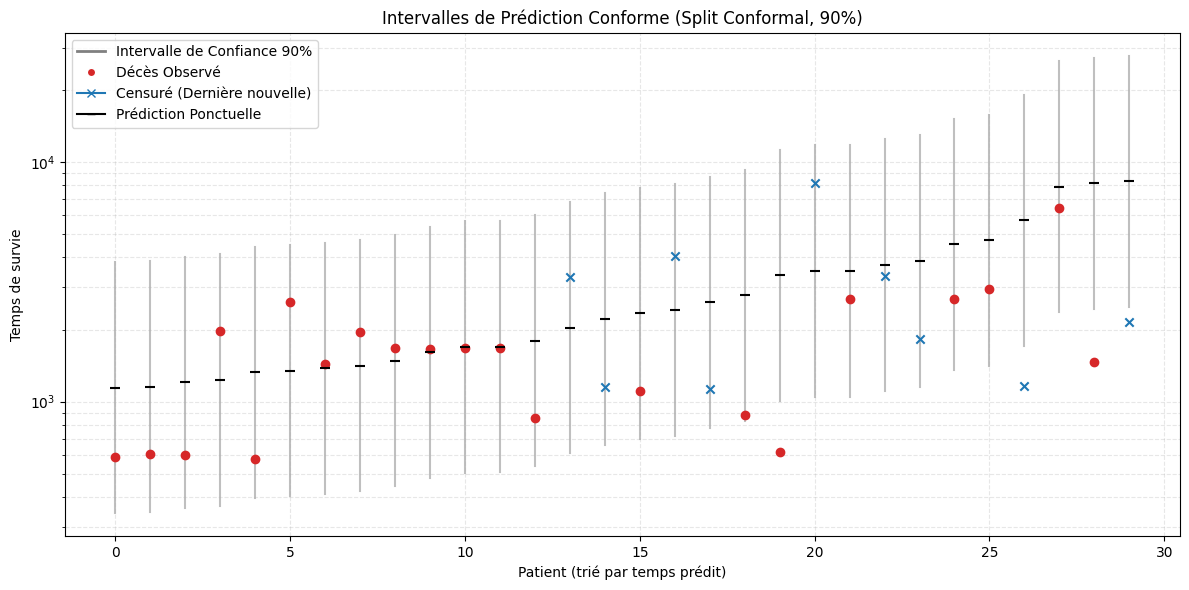

In [ ]:
from matplotlib.lines import Line2D

# Sélection d'un échantillon aléatoire
sample_df = df_results.sample(30, seed=123).sort("predicted_time")
sample_pd = sample_df.to_pandas().reset_index(drop=True)

plt.figure(figsize=(12, 6))

for i, row in sample_pd.iterrows():
    # Couleur selon l'événement (Rouge=Décès observé, Bleu=Censuré)
    color = "tab:red" if row["event"] else "tab:blue"
    marker = "o" if row["event"] else "x"

    # Barre d'intervalle de prédiction
    plt.plot(
        [i, i],
        [row["lower_bound"], row["upper_bound"]],
        color="gray",
        alpha=0.5,
        zorder=1,
    )

    # Point réel
    plt.scatter(
        i,
        row["observed_time"],
        color=color,
        marker=marker,
        zorder=2,
        label="Observed" if i == 0 else "",
    )

    # Point prédit (médiane modèle)
    plt.scatter(i, row["predicted_time"], color="black", marker="_", zorder=2, s=50)

legend_elements = [
    Line2D(
        [0], [0], color="gray", lw=2, label=f"Intervalle de Confiance {1 - ALPHA:.0%}"
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="tab:red",
        label="Décès Observé",
    ),
    Line2D([0], [0], marker="x", color="tab:blue", label="Censuré (Dernière nouvelle)"),
    Line2D([0], [0], marker="_", color="black", label="Prédiction Ponctuelle"),
]

plt.legend(handles=legend_elements)
plt.title(f"Intervalles de Prédiction Conforme (Split Conformal, {1 - ALPHA:.0%})")
plt.xlabel("Patient (trié par temps prédit)")
plt.ylabel("Temps de survie")
plt.yscale("log")  # Échelle log souvent plus lisible en survie
plt.grid(label=True, which="both", linestyle="--", alpha=0.3)
plt.tight_layout()